/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:40: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
No handles with labels found to put in legend.


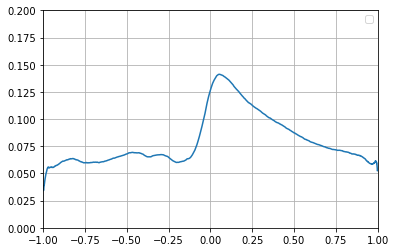

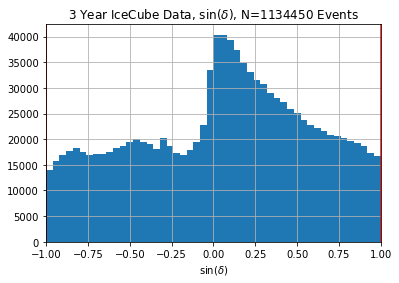

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate

# Looking to calculate B_i
# we do this by scrambling data in a 6 degree
# elevation angle band in the sky
# We can't use a histogram since there is spill over between bands

# Load up the IceCube data
icecube_data = np.load("./processed_data/output_icecube_data.npz",
                       allow_pickle=True)
data_dec = np.array(icecube_data["data_dec"])

# size of bins
size_of_band = 3.0
sweep_lowerlimit = -87.0
sweep_upperlimit = 87.0

# sweep over different sin decs to calculate the B_i at that point
sweep_dec = np.linspace(sweep_lowerlimit, sweep_upperlimit, 1000)

# Count number of entries in bin
entries_in_bands = np.abs(data_dec[:, np.newaxis] - sweep_dec) < size_of_band
entries_in_bands = np.sum(entries_in_bands, axis=0)

solid_angles = (2.0 * np.pi *
                np.sin(np.deg2rad(size_of_band)) *
                np.cos(np.deg2rad(sweep_dec)))
event_per_solid_angle = entries_in_bands / solid_angles

f_sweep = scipy.interpolate.interp1d(np.sin(np.deg2rad(sweep_dec)),
                                     event_per_solid_angle,
                                     kind='cubic',
                                     bounds_error=False,
                                     fill_value=0.0)

# to perform the average, integrate over result and divide it out
sweep_counts_norm, err = scipy.integrate.quad(f_sweep, -1, 1)

# equation 2.2 in the paper
P_B = event_per_solid_angle / sweep_counts_norm
B_i = P_B / (2.0 * np.pi)

np.savez("./processed_data/output_icecube_background_count.npz",
         dec=sweep_dec,
         B_i=B_i)

plt.figure()
plt.plot(np.sin(np.deg2rad(sweep_dec)), B_i)
plt.xlim(-1.0, 1.0)
plt.ylim(0.0, 0.2)
plt.legend()
plt.grid()

# make a figure of the data sin dec, just a raw plot
plt.figure()
plt.title("3 Year IceCube Data, $\sin(\delta)$, N="+str(len(data_dec))+" Events")
plt.hist(np.sin(np.deg2rad(data_dec)), range=(-1, 1), bins=50)
plt.xlabel("$\sin(\delta)$")
plt.xlim(-1.0, 1.0)
plt.axvline(np.sin(np.deg2rad(sweep_lowerlimit)), color='red')
plt.axvline(np.sin(np.deg2rad(sweep_upperlimit)), color='red')
plt.grid()
plt.show()